In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

from jupyterthemes import jtplot
jtplot.style(theme="grade3")

In [2]:
def cap(x,quantile=[0.01,0.99]):
    """
    CAP Algorithm to delete the outliers
    
    Args：
        x：pd.Series
        quantile：upper/lower boundary in precentage
    """

    Q01,Q99=x.quantile(quantile).values.tolist()

    if Q01 > x.min():
        x = x.copy()
        x.loc[x<Q01] = Q01

    if Q99 < x.max():
        x = x.copy()
        x.loc[x>Q99] = Q99

    return(x)

# Load Data

In [3]:
dataSize = ['256', '512', '1K', '2K', '4K', '8K', '16K', '32K', '64K', '128K', '256K', '512K', '1M', '2M', '4M']

np_unload = np.zeros([600, len(dataSize)])
np_load = np.zeros([600, len(dataSize)])

for i in range(len(dataSize)):
    np_unload[:, i] = np.loadtxt("./q6/unload/transport_time_"+dataSize[i]+"byte.txt", dtype=np.float64)
    np_load[:, i] = np.loadtxt("./q6/load/transport_time_"+dataSize[i]+"byte.txt", dtype=np.float64)
    
# convert s to ms
np_unload = np_unload * 1000
np_load = np_load * 1000

# Make pd.Dataframe

In [4]:
pd_unload = pd.DataFrame(np_unload, columns=dataSize)
pd_load = pd.DataFrame(np_load, columns=dataSize)

# Data Preprocessing

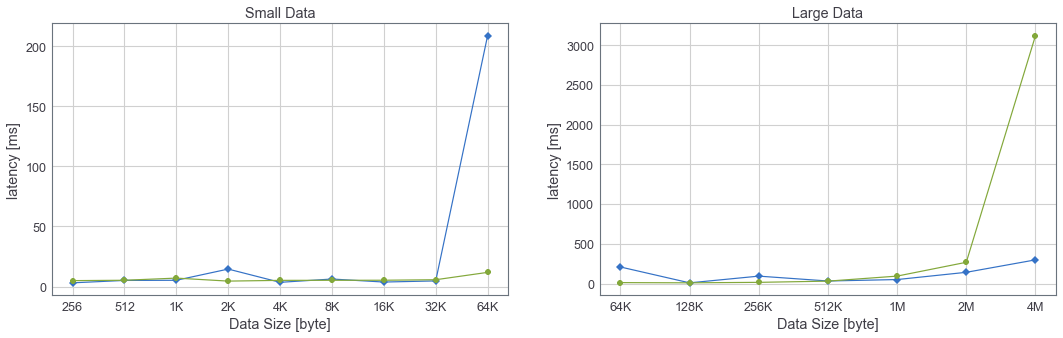

In [5]:
smallSize = dataSize[:9]
largeSize = dataSize[8:]

plt.figure(num=1, figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(smallSize, pd_unload[smallSize].mean(), "-D")
plt.plot(smallSize, pd_load[smallSize].mean(), "-8")
plt.xlabel("Data Size [byte]")
plt.ylabel("latency [ms]")
plt.title("Small Data")
plt.subplot(1,2,2)
plt.plot(largeSize, pd_unload[largeSize].mean(), "-D")
plt.plot(largeSize, pd_load[largeSize].mean(), "-8")
plt.xlabel("Data Size [byte]")
plt.ylabel("latency [ms]")
plt.title("Large Data")
plt.show()

In [6]:
# print(pd_unload.mean())
# print()
# print(pd_load.mean())

In [7]:
# preprocess for unloaded data
for i in dataSize[:10]:
    pd_unload[i] = pd_unload[i].drop(pd_unload[pd_unload[i]>20].index)
for i in dataSize[10:13]:
    pd_unload[i] = pd_unload[i].drop(pd_unload[pd_unload[i]>100].index)
for i in dataSize[13:]:
    pd_unload[i] = pd_unload[i].drop(pd_unload[pd_unload[i]>1000].index)

# preprocess for loaded data
for i in dataSize[:3]:
    pd_load[i] = pd_load[i].drop(pd_load[pd_load[i]>50].index)

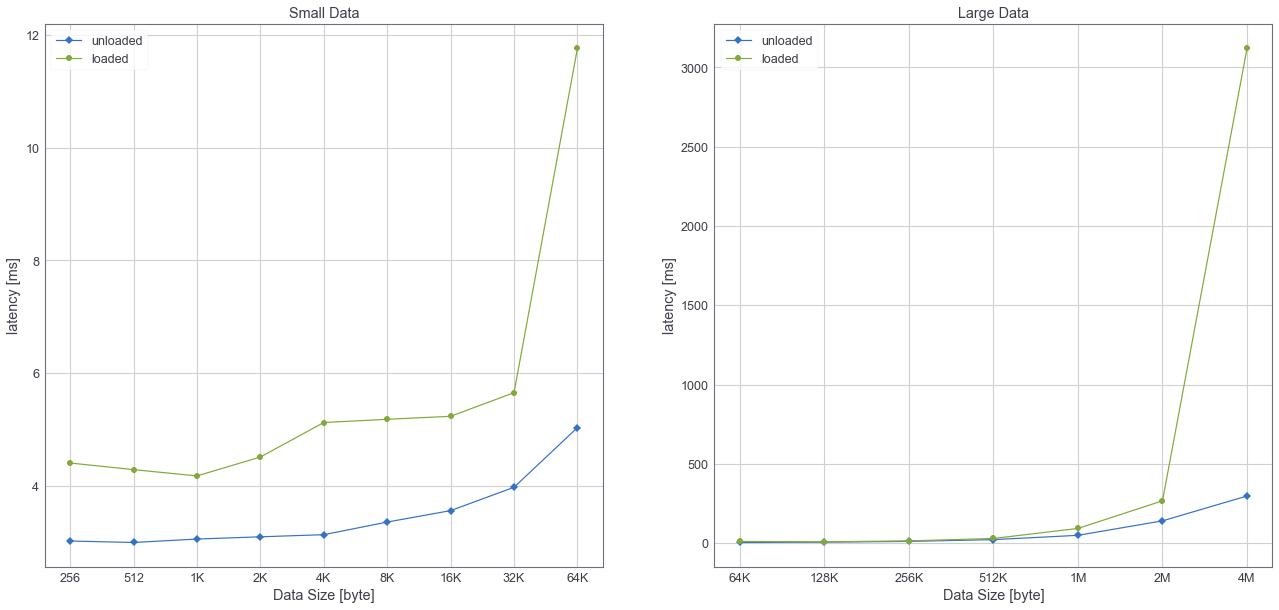

In [8]:
plt.figure(num=1, figsize=(22,10))
plt.subplot(1,2,1)
plt.plot(smallSize, pd_unload[smallSize].mean(), "-D")
plt.plot(smallSize, pd_load[smallSize].mean(), "-8")
plt.xlabel("Data Size [byte]")
plt.ylabel("latency [ms]")
plt.legend(["unloaded", "loaded"])
plt.title("Small Data")
plt.subplot(1,2,2)
plt.plot(largeSize, pd_unload[largeSize].mean(), "-D")
plt.plot(largeSize, pd_load[largeSize].mean(), "-8")
plt.xlabel("Data Size [byte]")
plt.ylabel("latency [ms]")
plt.legend(["unloaded", "loaded"])
plt.title("Large Data")
plt.savefig("./q6/figure/q6_mean.pdf", dpi=1200)
plt.show()

# Boxplot

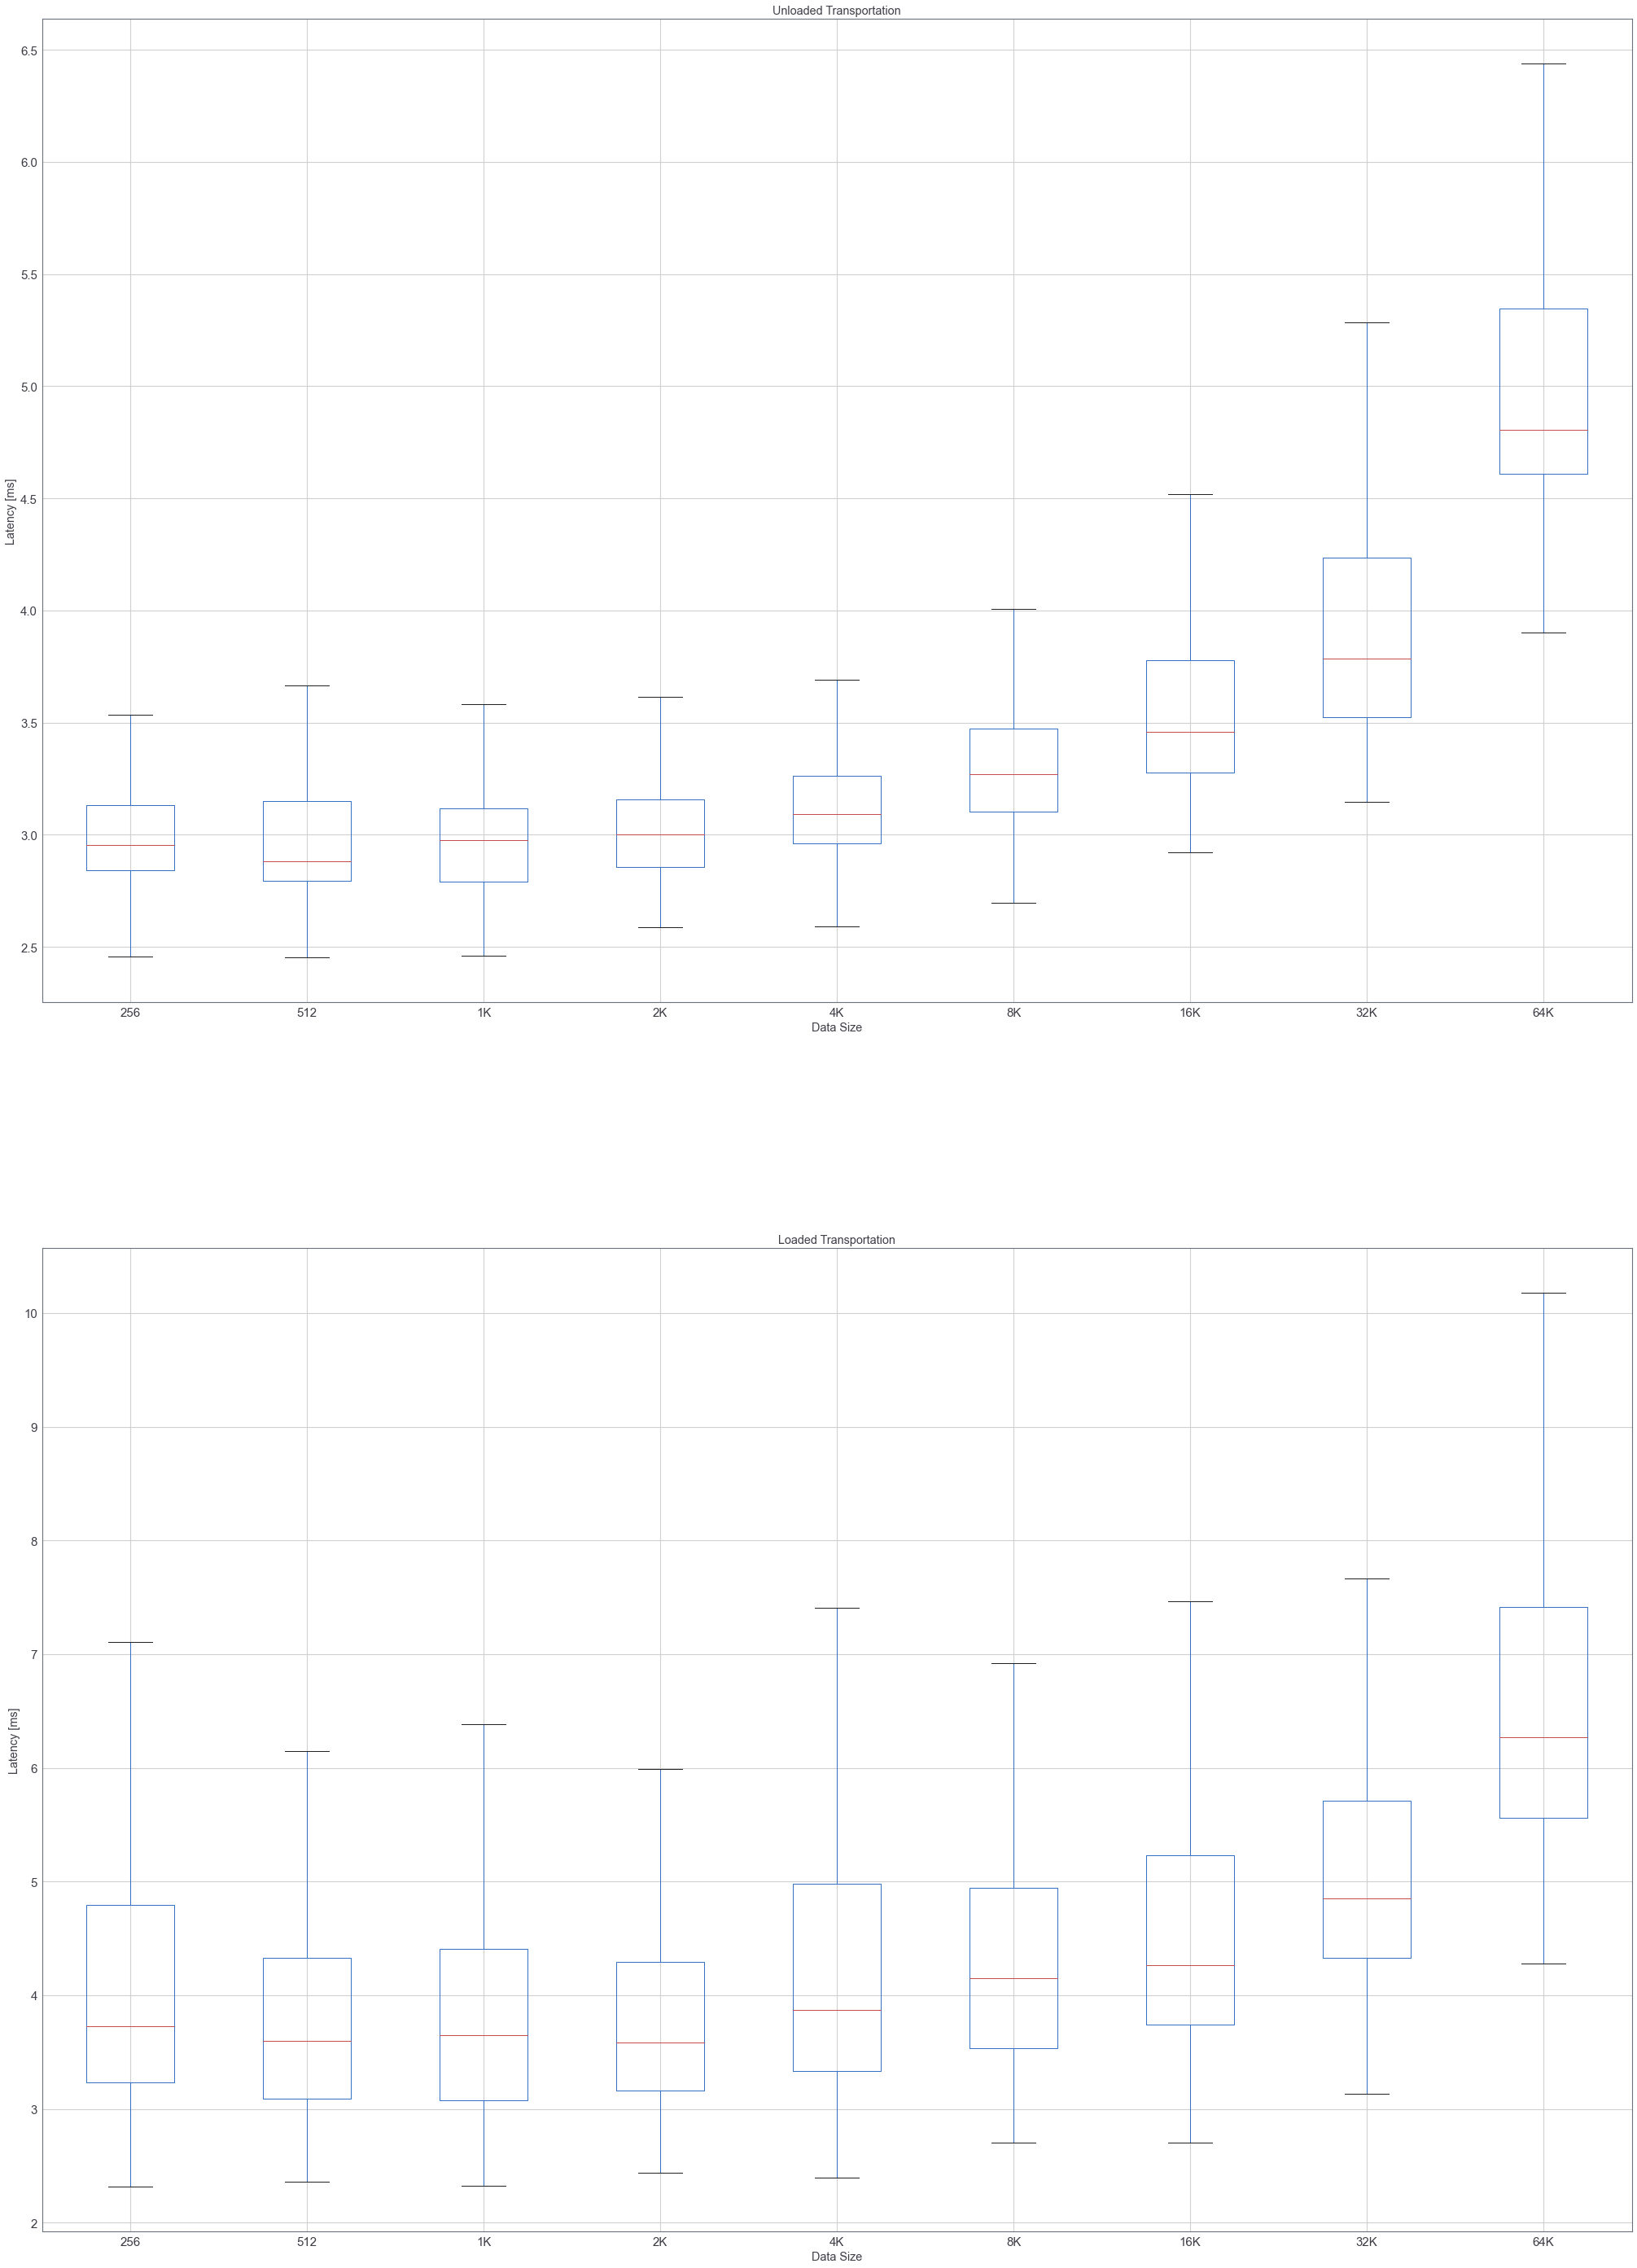

In [9]:
plt.figure(num=2, figsize=(35,50))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2,1,1)
boxplot = pd_unload[smallSize].boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Size")
boxplot.set_title("Unloaded Transportation")
plt.subplot(2,1,2)
boxplot = pd_load[smallSize].boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Size")
boxplot.set_title("Loaded Transportation")
plt.savefig("./q6/figure/q6_boxplot_small.pdf", dpi=1200)

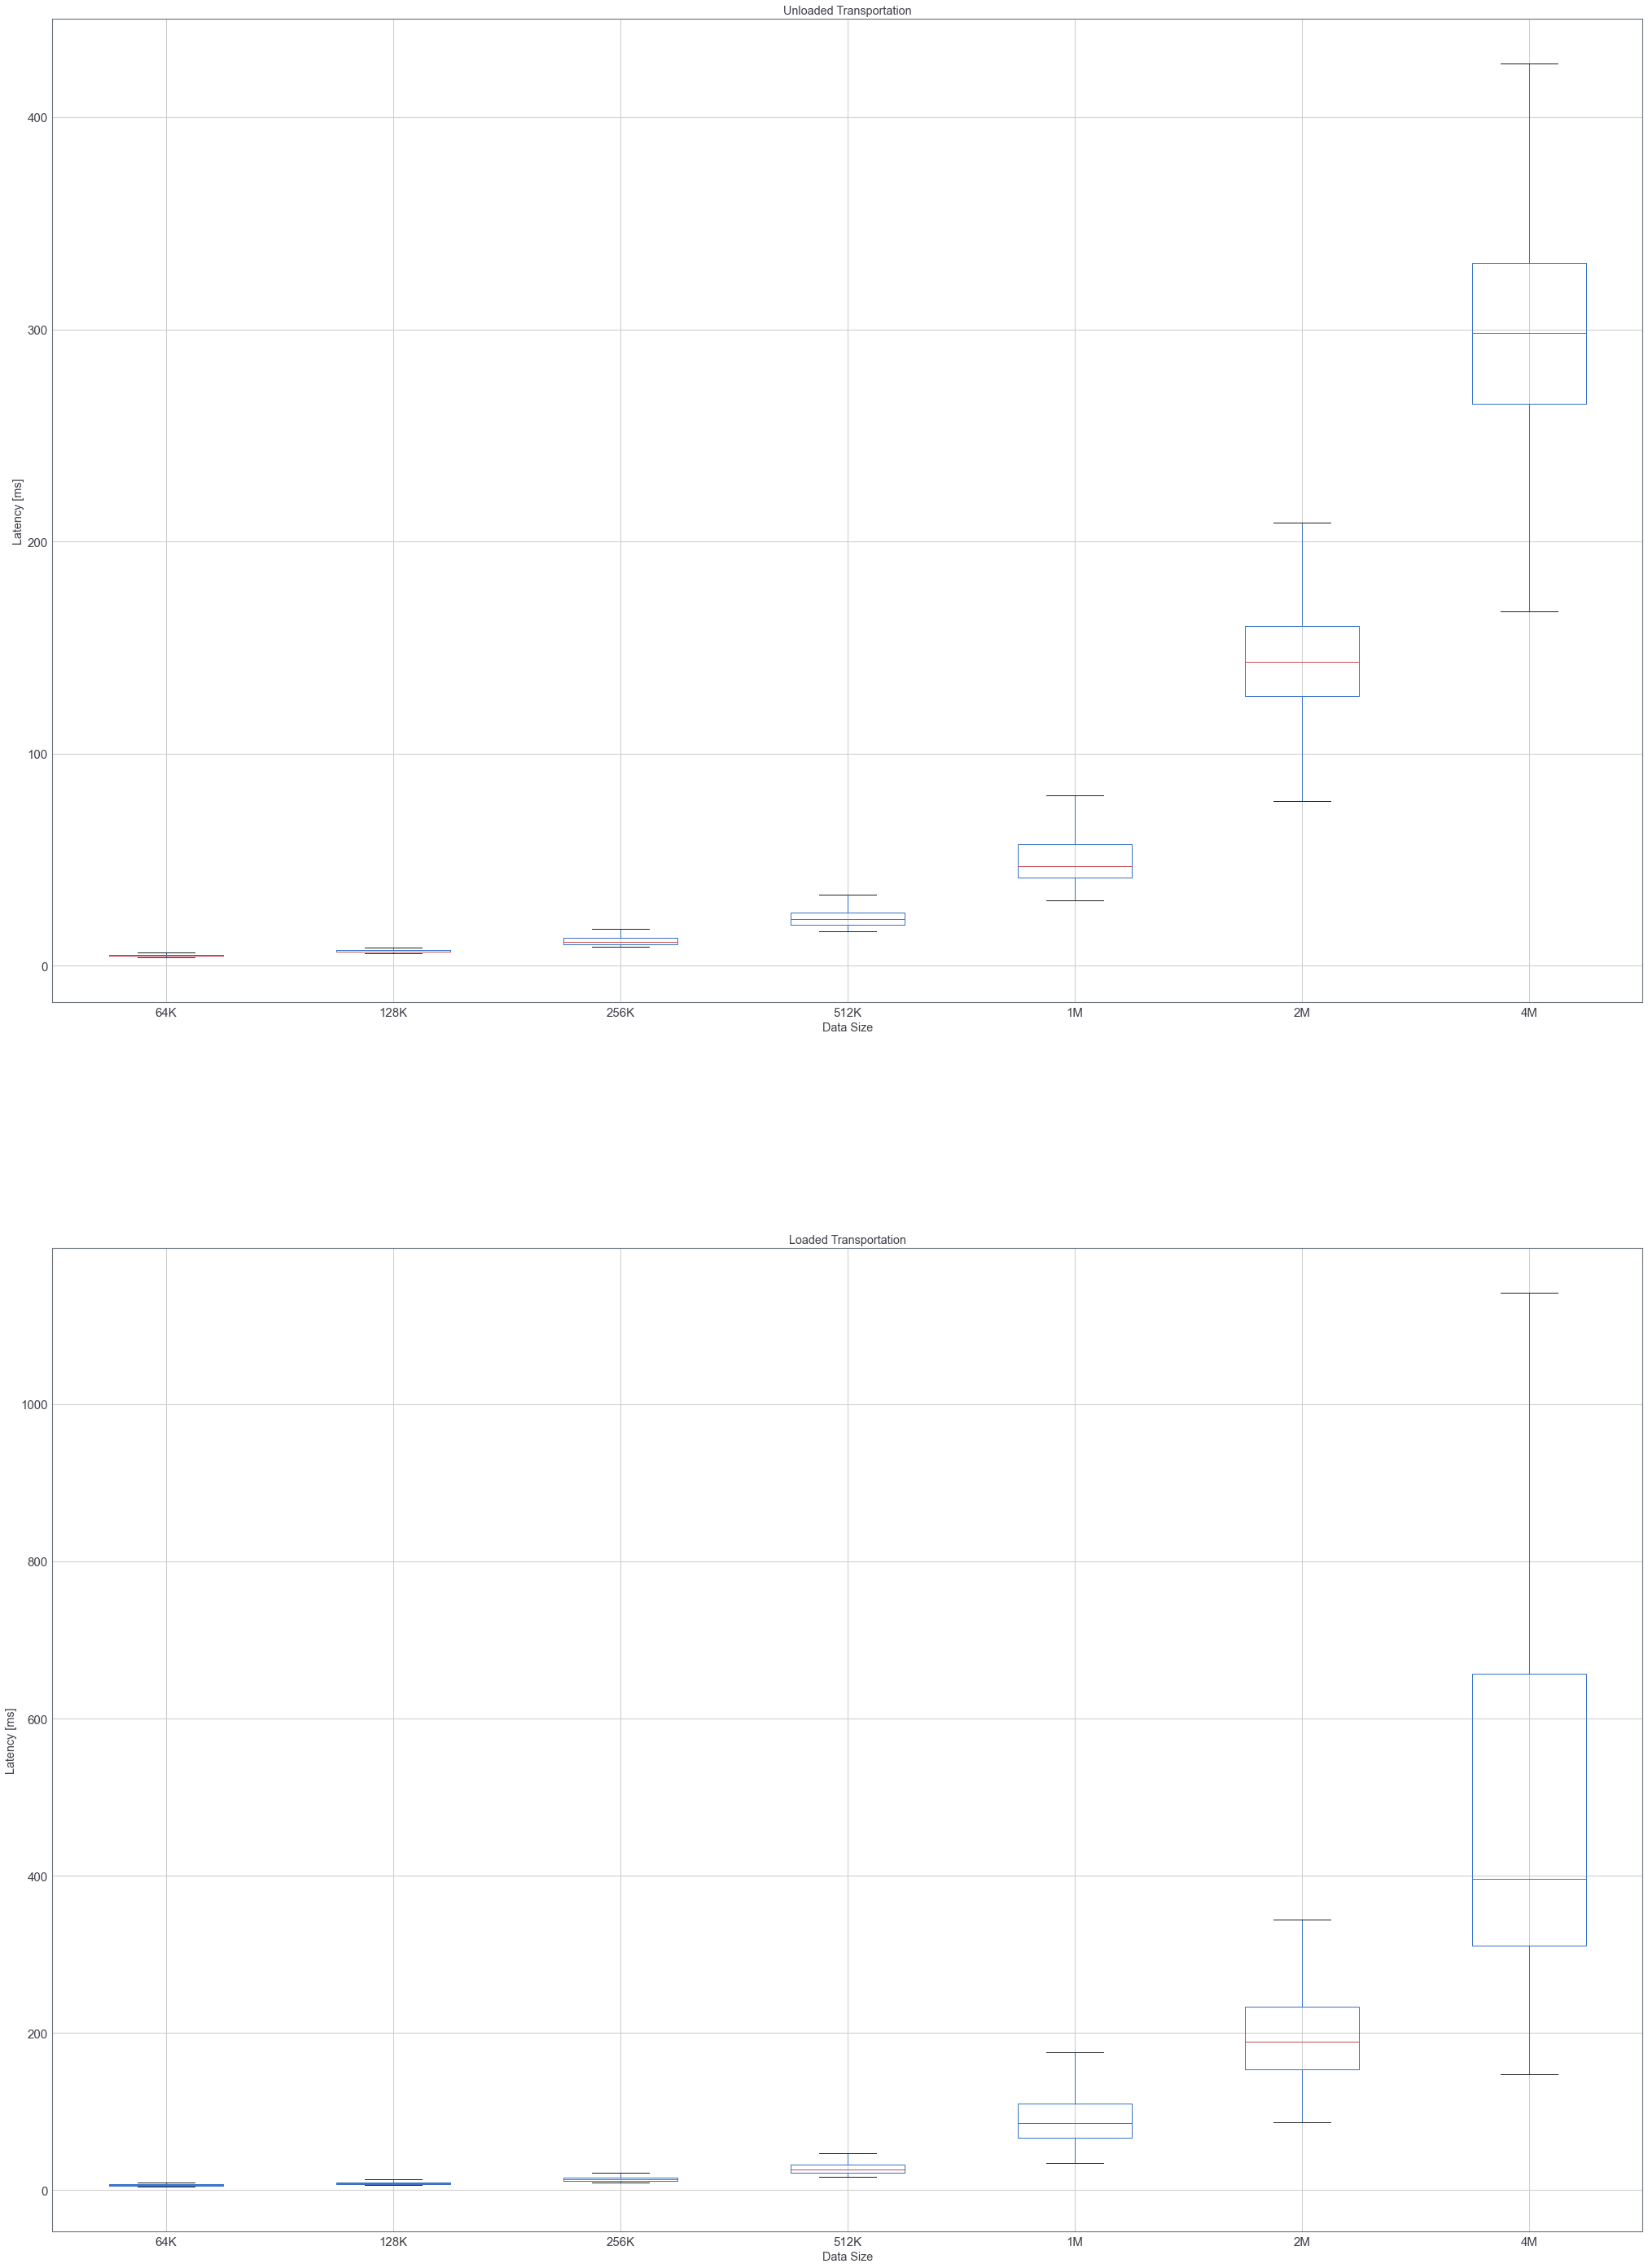

In [10]:
plt.figure(num=3, figsize=(35,50))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2,1,1)
boxplot = pd_unload[largeSize].boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Size")
boxplot.set_title("Unloaded Transportation")
plt.subplot(2,1,2)
boxplot = pd_load[largeSize].boxplot(fontsize=15, showfliers=False)
boxplot.set_ylabel("Latency [ms]")
boxplot.set_xlabel("Data Size")
boxplot.set_title("Loaded Transportation")
plt.savefig("./q6/figure/q6_boxplot_large.pdf", dpi=1600)

# ANOVA

In [11]:
anova = pd.DataFrame({
    "latency": np.hstack((pd_unload, pd_load)).flatten("F"),
    
    "Network": np.repeat(["unloaded", "loaded"], 15*600),
    
    "Data_Size": np.r_[np.repeat(dataSize, 600),
                           np.repeat(dataSize, 600)]
})

In [12]:
model_summary = rp.summary_cont(anova.groupby(['Network', 'Data_Size']), conf = 0.8)['latency']
model_summary

N       Mean         SD        SE  80% Conf.   Interval
Network  Data_Size                                                           
loaded   128K       600     9.1897     2.7389    0.1118     9.0463     9.3332
         16K        600     5.2305    10.9500    0.4470     4.6570     5.8040
         1K         591     4.1712     2.9793    0.1226     4.0140     4.3285
         1M         600    93.6546    36.9179    1.5072    91.7210    95.5883
         256        596     4.4006     2.5139    0.1030     4.2685     4.5327
         256K       600    15.1018     4.3621    0.1781    14.8733    15.3302
         2K         600     4.5070     7.4645    0.3047     4.1160     4.8979
         2M         600   267.7082  1121.7723   45.7962   208.9532   326.4631
         32K        600     5.6498     5.0542    0.2063     5.3851     5.9145
         4K         600     5.1201     8.1476    0.3326     4.6933     5.5468
         4M         600  3120.5878  7416.3491  302.7712  2732.1426  3509.0331
         512        596     4.2827     3.4413    0.1410     4.1019     4.4636
         512K       600    30.3029    12.9964    0.5306    29.6222    30.9836
         64K        600    11.7683    99.5013    4.0621     6.5568    16.9799
         8K         600     5.1771     7.2918    0.2977     4.7952     5.5590
unloaded 128K       599     7.1849     0.8187    0.0335     7.1420     7.2279
         16K        599     3.5549     0.3949    0.0161     3.5342     3.5756
         1K         593     3.0495     0.8556    0.0351     3.0045     3.0946
         1M         600    50.2090    11.2737    0.4602    49.6185    50.7995
         256        599     3.0147     0.4804    0.0196     2.9895     3.0399
         256K       584    11.9817     3.1904    0.1320    11.8124    12.1511
         2K         581     3.0894     0.7040    0.0292     3.0519     3.1269
         2M         600   141.4925    30.6568    1.2516   139.8868   143.0982
         32K        597     3.9693     0.8286    0.0339     3.9258     4.0128
         4K         597     3.1270     0.2838    0.0116     3.1121     3.1419
         4M         600   298.2049    57.3134    2.3398   295.2030   301.2068
         512        593     2.9884     0.3593    0.0148     2.9694     3.0073
         512K       598    23.0267     5.0232    0.2054    22.7632    23.2902
         64K        557     5.0296     0.6784    0.0287     4.9927     5.0665
         8K         592     3.3513     0.4828    0.0198     3.3259     3.3768

In [13]:
model_summary.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n         &    &    N &       Mean &         SD &        SE &  80\\% Conf. &   Interval \\\\\nNetwork & Data\\_Size &      &            &            &           &            &            \\\\\n\\midrule\nloaded & 128K &  600 &     9.1897 &     2.7389 &    0.1118 &     9.0463 &     9.3332 \\\\\n         & 16K &  600 &     5.2305 &    10.9500 &    0.4470 &     4.6570 &     5.8040 \\\\\n         & 1K &  591 &     4.1712 &     2.9793 &    0.1226 &     4.0140 &     4.3285 \\\\\n         & 1M &  600 &    93.6546 &    36.9179 &    1.5072 &    91.7210 &    95.5883 \\\\\n         & 256 &  596 &     4.4006 &     2.5139 &    0.1030 &     4.2685 &     4.5327 \\\\\n         & 256K &  600 &    15.1018 &     4.3621 &    0.1781 &    14.8733 &    15.3302 \\\\\n         & 2K &  600 &     4.5070 &     7.4645 &    0.3047 &     4.1160 &     4.8979 \\\\\n         & 2M &  600 &   267.7082 &  1121.7723 &   45.7962 &   208.9532 &   326.4631 \\\\\n         & 32K &  600 &  

In [14]:
model = ols('latency ~ C(Network) + C(Data_Size) + C(Network)*C(Data_Size)', anova).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 29, 17842) =  102.437, p =  0.0000


In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                latency   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     102.4
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:31:52   Log-Likelihood:            -1.5449e+05
No. Observations:               17872   AIC:                         3.090e+05
Df Residuals:                   17842   BIC:                         3.093e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       9.1897     56.115      0.164      0.870    -100.802     119.181
C(Network)[T.unloaded]                         -2.0048     79.392     -0.025      0.980    -157.621     153.611
C(Data_Size)[T.16K]                            -3.9592     79.359     -0.050      0.960    -159.510     151.592
C(Data_Size)[T.1K]                             -5.0185     79.660     -0.063      0.950    -161.161     151.124
C(Data_Size)[T.1M]                             84.4649     79.359      1.064      0.287     -71.086     240.016
C(Data_Size)[T.256]                            -4.7891     79.492     -0.060      0.952    -160.601     151.023
C(Data_Size)[T.256K]                            5.9120     79.359      0.074      0.941    -149.639     161.463
C(Data_Size)[T.2K]                             -4.6828     79.359     -0.059      0.953    -160.234     150.868
C(Data_Size)[T.2M]                            258.5185     79.359      3.258      0.001     102.967     414.070
C(Data_Size)[T.32K]                            -3.5399     79.359     -0.045      0.964    -159.091     152.011
C(Data_Size)[T.4K]                             -4.0696     79.359     -0.051      0.959    -159.621     151.482
C(Data_Size)[T.4M]                           3111.3981     79.359     39.207      0.000    2955.847    3266.949
C(Data_Size)[T.512]                            -4.9070     79.492     -0.062      0.951    -160.719     150.905
C(Data_Size)[T.512K]                           21.1132     79.359      0.266      0.790    -134.438     176.664
C(Data_Size)[T.64K]                             2.5786     79.359      0.032      0.974    -152.973     158.130
C(Data_Size)[T.8K]                             -4.0126     79.359     -0.051      0.960    -159.564     151.539
C(Network)[T.unloaded]:C(Data_Size)[T.16K]      0.3291    112.277      0.003      0.998    -219.745     220.403
C(Network)[T.unloaded]:C(Data_Size)[T.1K]       0.8831    112.632      0.008      0.994    -219.887     221.653
C(Network)[T.unloaded]:C(Data_Size)[T.1M]     -41.4409    112.254     -0.369      0.712    -261.469     178.588
C(Network)[T.unloaded]:C(Data_Size)[T.256]      0.6189    112.371      0.006      0.996    -219.640     220.878
C(Network)[T.unloaded]:C(Data_Size)[T.256K]    -1.1153    112.637     -0.010      0.992    -221.896     219.665
C(Network)[T.unloaded]:C(Data_Size)[T.2K]       0.5872    112.712      0.005      0.996    -220.339     221.513
C(Network)[T.unloaded]:C(Data_Size)[T.2M]    -124.2109    112.254     -1.107      0.269    -344.239      95.818
C(Network)[T.unloaded]:C(Data_Size)[T.32K]      0.3242    112.324      0.003      0.998    -219.842     220.491
C(Network)[T.unloaded]:C(Data_Size)[T.4K]       0.0117    1

In [16]:
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Network),1.841260e+08,1.0,97.454607,6.308912e-23
C(Data_Size),3.220041e+09,14.0,121.736469,0.000000e+00
C(Network):C(Data_Size),2.211012e+09,14.0,83.589237,2.857745e-233
Residual,3.370981e+10,17842.0,NaN,NaN


In [17]:
res.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &        sum\\_sq &       df &           F &         PR(>F) \\\\\n\\midrule\nC(Network)              &  1.841260e+08 &      1.0 &   97.454607 &   6.308912e-23 \\\\\nC(Data\\_Size)            &  3.220041e+09 &     14.0 &  121.736469 &   0.000000e+00 \\\\\nC(Network):C(Data\\_Size) &  2.211012e+09 &     14.0 &   83.589237 &  2.857745e-233 \\\\\nResidual                &  3.370981e+10 &  17842.0 &         NaN &            NaN \\\\\n\\bottomrule\n\\end{tabular}\n'